In [1]:
import torch
from conex import *
from pymonntorch import *

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

from tqdm import tqdm

from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader

from conex.helpers.filters import DoGFilter

In [2]:
def load_image(path,size = None):
    img = cv2.imread(path)
    if(size):
        img = cv2.resize(img,size)
    return torch.tensor(img[:,:,0],dtype=torch.float32)

def show_image(image,normal=False):
    plt.axis("off")
    if(normal):
        plt.imshow(image,cmap='gray',vmin=0,vmax=255)
    else:
        plt.imshow(image,cmap='gray')
    plt.show()
    

def show_filters(weight):
    fig,axes = plt.subplots(1,weight.shape[0])
    fig.set_size_inches(5*weight.shape[0], 5)
    # fig.suptitle(f'plots of synaptic share weights for d = {weight.shape[0]}')
    for i in range(weight.shape[0]):
        axes[i].imshow(weight[i][0],cmap='gray')
        axes[i].axis('off')
        
        
def show_images(imgs,title,count):
    fig,axes = plt.subplots(1,count)
    fig.set_size_inches(5*count, 5)
    plt.text(x=0.5, y=0.94, s=title, fontsize=28, ha="center", transform=fig.transFigure)
    for i in range(count):
        axes[i].imshow(imgs[i][0][0],cmap='gray')
        axes[i].axis('off')


def confidence_crop_interspace(inp_width, inp_height, window_width, window_height):
    x1 = window_width//2
    x2 = (inp_width - 1) - (window_width//2)
    y1 = window_height//2 
    y2 = (inp_height - 1) - (window_height//2)

    center_x = random.randint(x1, x2)
    center_y = random.randint(y1, y2)
    center_coordinates = [center_x, center_y]
    top_left_x = center_x - (window_width//2)
    top_left_y = center_y - (window_height//2)
    top_left_coordinates = [top_left_x, top_left_y]
    coordinates = [center_coordinates, top_left_coordinates]

    return coordinates


In [3]:
from FC import fullyConnected
from FC.synapse.learning import AttentionBasedRSTDP

In [4]:
from torchvision.datasets import MNIST
MNIST_ROOT = "./MNIST"

# CONFIG

In [5]:
Input_Width = 28
Input_Height = 28
Crop_Window_Width = 21
Crop_Window_Height = 21
DoG_SIZE = 5

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

OUT_CHANNEL = 8
IN_CHANNEL = 1
KERNEL_WIDTH = 13
KERNEL_HEIGHT = 13

# INPUT_WIDTH = IMAGE_WIDTH - DoG_SIZE + 1
# INPUT_HEIGHT = IMAGE_HEIGHT - DoG_SIZE + 1
INPUT_WIDTH = Crop_Window_Width - DoG_SIZE + 1
INPUT_HEIGHT = Crop_Window_Height - DoG_SIZE + 1

L4_WIDTH = INPUT_WIDTH - KERNEL_WIDTH + 1
L4_HEIGHT = INPUT_HEIGHT - KERNEL_HEIGHT + 1

L23_WIDTH = L4_WIDTH//2
L23_HEIGHT = L4_HEIGHT//2

J_0 = 300
p = 0.8

# DataLoader

In [6]:
time_window = 100
crop_iteration = 3

dataset_directory_path = "./first_step"

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels = 1), # not necessary
    Conv2dFilter(DoGFilter(size = 5, sigma_1 = 4, sigma_2 = 1, zero_mean=True, one_sum=True).unsqueeze(0).unsqueeze(0)),
    SqueezeTransform(dim = 0),
    SimplePoisson(time_window = time_window , ratio = 2),
])


dataset = MNIST(root=MNIST_ROOT, train=True, download=False, transform=transformation)
first_class = dataset.data[dataset.targets == 4][:40]
second_class = dataset.data[dataset.targets == 9][:40]

target = [0] * len(first_class) + [1] * len(second_class)
target = torch.Tensor(target)

two_class_dataset = torch.cat((first_class, second_class), dim=0)
new_dataset_size = first_class.shape[0] + second_class.shape[0]

t = torch.arange(new_dataset_size)
np.random.shuffle(t.numpy())
two_class_dataset = two_class_dataset[t]
target = target[t]

target_new = [[i] * (time_window * crop_iteration + 100) for i in target]
target_new = torch.Tensor(target_new)
target = target_new.view(-1)

new_dataset = torch.empty(0,Crop_Window_Width - DoG_SIZE + 1, Crop_Window_Height - DoG_SIZE + 1)
centers = []


for i in tqdm(range(0, new_dataset_size)):
    for j in range (0, crop_iteration):
        img = two_class_dataset[i]  # 4 in range [0, 5842) ; 9 in range [5842, 11791)
        img = Image.fromarray(img.numpy(), mode="L")
        a = confidence_crop_interspace(Input_Width, Input_Height, Crop_Window_Width, Crop_Window_Height)
        centers.append((a[0][0], a[0][1]))
        cropped_image = torchvision.transforms.functional.crop(img, a[1][1], a[1][0], Crop_Window_Width, Crop_Window_Height)
        # cropped_image = Image.fromarray(cropped_image.numpy(), mode="L")
        # cropped_image = img
        cropped_image = transformation(cropped_image)
        cropped_image = cropped_image.view(time_window, Crop_Window_Width - DoG_SIZE + 1, Crop_Window_Height - DoG_SIZE + 1)
        new_dataset = torch.cat((new_dataset.data, cropped_image.data), dim=0)

new_dataset = new_dataset.view((new_dataset_size, crop_iteration * time_window, INPUT_WIDTH, INPUT_HEIGHT))
print(new_dataset.shape)
dl = DataLoader(new_dataset,shuffle=False)


100%|██████████| 80/80 [00:00<00:00, 107.47it/s]

torch.Size([80, 300, 17, 17])


In [7]:
class SetTarget(Behavior) :

    def initialize(self, network) : 
        self.network_target = self.parameter("target", required = True)
        network.targets = self.network_target[0]

    def forward(self, network) :

        network.targets = self.network_target[network.iteration]
        network.dopamine = torch.Tensor([network.dopamine_concentration])

In [8]:
net = Neocortex(dt=1, dtype=torch.float32, behavior = {5 : SetTarget(target = target), 601 : Recorder(["dopamine"])})


#################### Input Layer ####################




input_layer = InputLayer(
    net=net,
    input_dataloader = dl,
    sensory_data_dim=2,
    sensory_size = NeuronDimension(depth=1, height = INPUT_HEIGHT, width = INPUT_WIDTH),
    sensory_trace = 3,
    instance_duration = time_window,
    have_label = False,
    silent_interval = 100,
    output_ports = {
        "data_out": (None,[("sensory_pop", {})])
    }
)




#################### L4 ####################



ng4e = NeuronGroup(size = NeuronDimension(depth = OUT_CHANNEL , height = L4_HEIGHT, width = L4_WIDTH), net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        init_v = -65,
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70,
    ),
    KWTA(k=10),
    ActivityBaseHomeostasis(window_size=10, activity_rate=200, updating_rate=0.0001),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]))

ng4i = NeuronGroup(size = L4_HEIGHT * L4_WIDTH * OUT_CHANNEL // 4, net = net, tag = "inh", behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        init_v = -65,
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    # KWTA(k=30),
    Fire(),
    SpikeTrace(tau_s = 5, offset = 0),
    NeuronAxon(),
]))


sg4e4i = SynapseGroup(net = net, src = ng4e, dst = ng4i, tag = "Proximal", behavior = prioritize_behaviors([
    SimpleDendriticInput(),
    SynapseInit(),
    WeightInitializer(mode = "ones", scale = J_0/math.sqrt(1600 * p), density = 0.02, true_sparsity = False),
]))


sg4i4e = SynapseGroup(net = net, src = ng4i, dst = ng4e, tag = "Proximal", behavior = prioritize_behaviors([
    SimpleDendriticInput(),
    SynapseInit(),
    WeightInitializer(mode = "ones", scale = J_0/math.sqrt(1600 * p), density = 0.02, true_sparsity = False),
]))

sg4e4e = SynapseGroup(net = net, src = ng4e, dst = ng4e, tag = "Proximal", behavior=prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights=torch.Tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]).view(1, 1, 19, 1, 1)),
    LateralDendriticInput(current_coef=0, inhibitory = True),
]))


inh_lateral_weight = torch.ones((1, 1, 11, 7, 7))
inh_lateral_weight[0][0][5][3][3] = 0

sg4e4e_ah = SynapseGroup(net = net, src = ng4e, dst = ng4e, tag = "Proximal", behavior=prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights=inh_lateral_weight),
    LateralDendriticInput(current_coef=30000, inhibitory = True),
]))

sg4i4i = SynapseGroup(net = net, src = ng4i, dst = ng4i, tag = "Proximal", behavior = prioritize_behaviors([
    SimpleDendriticInput(),
    SynapseInit(),
    WeightInitializer(mode = "ones", scale = J_0/math.sqrt(1600 * p), density = 0.02, true_sparsity = False),
]))



#################### L2&3 ####################



ng23e = NeuronGroup(size = NeuronDimension(depth = OUT_CHANNEL , height = L23_HEIGHT, width = L23_WIDTH), net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        init_v = -65,
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]))

ng23i = NeuronGroup(size = L23_HEIGHT * L23_WIDTH * OUT_CHANNEL // 4, net = net, tag = "inh", behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        init_v = -65,
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]))

sg23e23i = SynapseGroup(net = net, src = ng23e, dst = ng23i, tag = "Proximal", behavior = prioritize_behaviors([
    SimpleDendriticInput(),
    SynapseInit(),
    WeightInitializer(mode = "ones", scale = J_0/math.sqrt(2500 * p), density = 0.02, true_sparsity = False),
]))

sg23i23e = SynapseGroup(net = net, src = ng23i, dst = ng23e, tag = "Proximal", behavior = prioritize_behaviors([
    SimpleDendriticInput(),
    SynapseInit(),
    WeightInitializer(mode = "ones", scale = J_0/math.sqrt(2500 * p), density = 0.02, true_sparsity = False),
]))

sg23i23i = SynapseGroup(net = net, src = ng23i, dst = ng23i, tag = "Proximal", behavior = prioritize_behaviors([
    SimpleDendriticInput(),
    SynapseInit(),
    WeightInitializer(mode = "ones", scale = J_0/math.sqrt(2500 * p), density = 0.02, true_sparsity = False),
]))



################### Layers ###################



L4 = CorticalLayer(
    net=net,
    excitatory_neurongroup=ng4e,
    inhibitory_neurongroup=ng4i,
    synapsegroups=[sg4e4i, sg4i4e, sg4e4e, sg4i4i, sg4e4e_ah],
    input_ports={
        "input": (
            None,
            [Port(object = ng4e, label = None)],
        ),
    },
    output_ports={
        "output": (
            None,
            [Port(object = ng4e, label = None)]
        )
    }
)



L23 = CorticalLayer(
    net=net,
    excitatory_neurongroup=ng23e,
    inhibitory_neurongroup=ng23i,
    synapsegroups=[sg23e23i, sg23i23e, sg23i23i],
    input_ports={
        "input": (
            None,
            [Port(object = ng23e, label = None)],
        ),
    },
    output_ports={
        "output": (
            None,
            [Port(object = ng23e, label = None)]
        )
    }
)



########### Inter Layer Connections ##########



Synapsis_L4_L23 = Synapsis(
    net = net,
    src = L4,
    dst = L23,
    input_port="output",
    output_port="input",
    synapsis_behavior=prioritize_behaviors([
        SynapseInit(),
        AveragePool2D(current_coef = 50000),
    ]),
    synaptic_tag="Proximal"
)

Synapsis_Inp_L4 = Synapsis(
    net = net,
    src = input_layer,
    dst = L4,
    input_port="data_out",
    output_port="input",
    synapsis_behavior=prioritize_behaviors([
        SynapseInit(),
        WeightInitializer(weights = torch.normal(0.1, 2, (OUT_CHANNEL, IN_CHANNEL, KERNEL_HEIGHT, KERNEL_WIDTH)) ),
        Conv2dDendriticInput(current_coef = 20000 , stride = 1, padding = 0),
        Conv2dSTDP(a_plus=0.3, a_minus=0.0008),
        WeightNormalization(norm = 4)
    ]),
    synaptic_tag="Proximal"
)

In [9]:
fclayer = fullyConnected.FC(net = net, N = 100, K = 2)

In [10]:
Synapsis_L23_FC = Synapsis(
    net = net,
    src = L23,
    dst = fclayer.layer,
    input_port="output",
    output_port="input",
    synapsis_behavior=prioritize_behaviors([
        SynapseInit(),
        WeightInitializer(mode = "random"),
        SimpleDendriticInput(current_coef = 20),
        WeightNormalization(norm = 13),
    ]) | ({
        400 : AttentionBasedRSTDP(a_plus = 0.8 , a_minus = 0.1, tau_c = 20, attention_plus = 1.5, attention_minus = -1),
    }),
    synaptic_tag="Proximal"
)

In [11]:
net.initialize()
net.simulate_iterations(16000)

Network['Neocortex'](Neurons: tensor(779)|7 groups, Synapses: tensor(210796)|14 groups){1:TimeResolution(dt=1,)5:SetTarget(target=tensor([1., 1., 1.,  ..., 1., 1., 1.]),)100:ConfidenceLevelPayOff(initial_payoff=0.0,punish=-0.8,reward=0.8,)120:Dopamine(tau_dopamine=50,initial_dopamine_concentration=None,)601:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['dopamine'],)}
NeuronGroup['Sensory', 'NeuronGroup', 'ng'](289){0:NeuronDimension(depth=1,height=17,width=17,input_patterns=None,)340:SensorySetter()360:SpikeTrace(tau_s=3,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](200){0:NeuronDimension(depth=8,height=5,width=5,input_patterns=None,)220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provoc

216953.80234718323

In [12]:
fclayer.E_NG_GROUP['spikes', 0][fclayer.E_NG_GROUP['spikes', 0][:,1] > 1600]

tensor([], size=(0, 2), dtype=torch.int64)

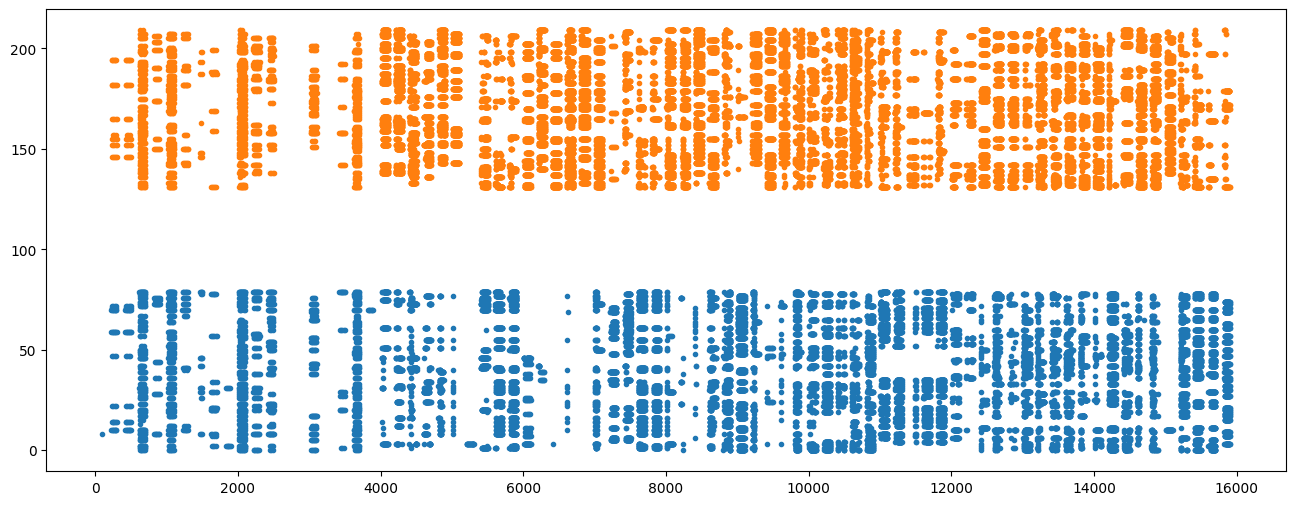

In [13]:
plt.figure(figsize=(16, 6))
# for i in range(fclayer.K) : 
    # a = (i * 1600)
    # b = ((i + 1) * 1600)
    
plt.plot(fclayer.E_NG_GROUP['spikes.t', 0][fclayer.E_NG_GROUP['spikes', 0][:,1] < 80], fclayer.E_NG_GROUP['spikes.i', 0][fclayer.E_NG_GROUP['spikes', 0][:,1] < 80], '.')
plt.plot(fclayer.E_NG_GROUP['spikes.t', 0][fclayer.E_NG_GROUP['spikes', 0][:,1] > 80], fclayer.E_NG_GROUP['spikes.i', 0][fclayer.E_NG_GROUP['spikes', 0][:,1] > 80] + 50, '.')

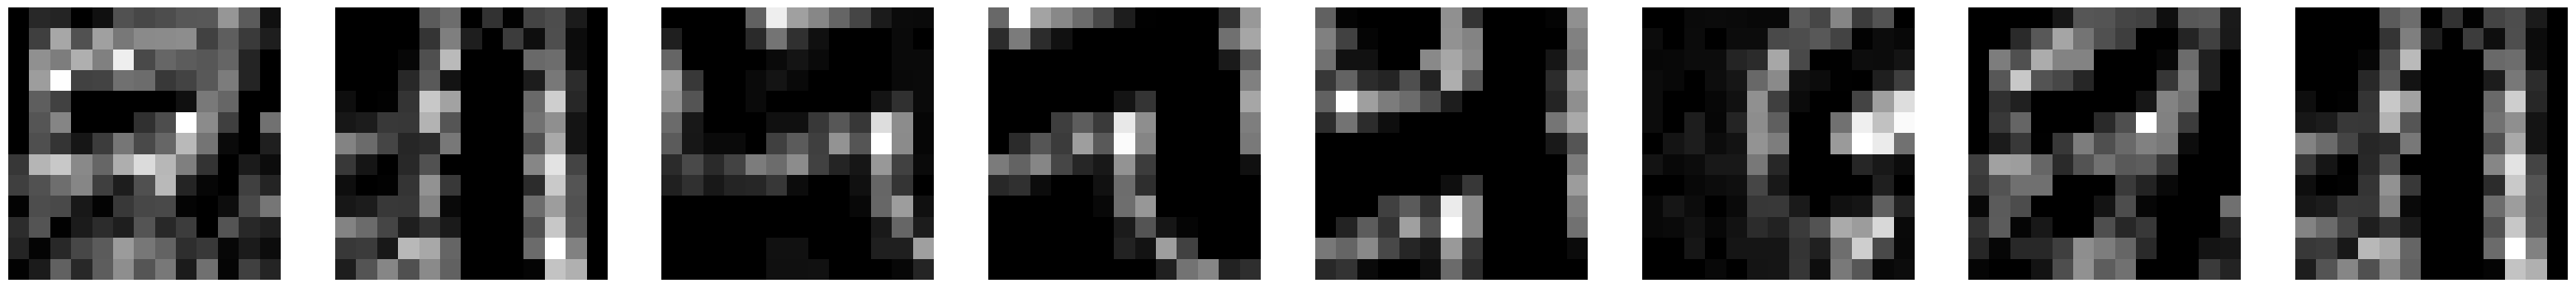

In [14]:
show_filters(Synapsis_Inp_L4.synapses[0].weights)

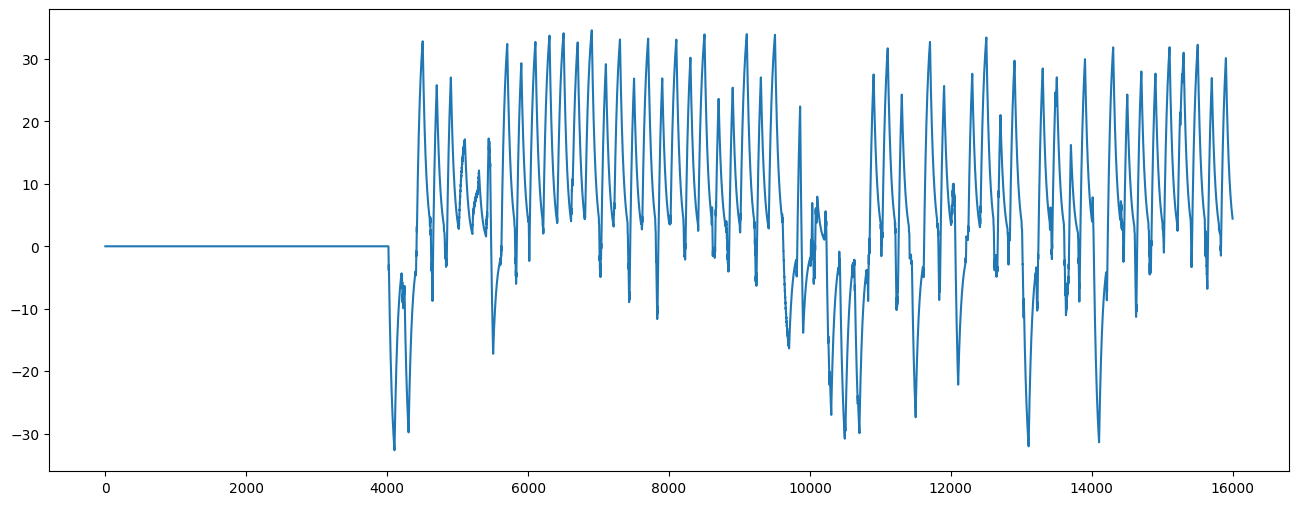

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(net["dopamine", 0])

In [16]:
# target[5000 : 6000]

In [17]:
import winsound
winsound.PlaySound("SystemExit", winsound.SND_ALIAS)